In [12]:
import numpy as np

from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
from scipy import stats

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F
torch.manual_seed(1)

import time
from datetime import datetime

from collections import defaultdict
from collections import Counter

from random import randint
import pickle

import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('error')

In [13]:
embedding_dim = 100
learning_rate = 0.025
epochs = 10
batch_size = 100

In [14]:
label='_hansard_en_smaller'

with open('pos_data' + label +'.p', 'rb') as f:
    pos_data = pickle.load(f)
    
with open('neg_data' + label +'.p', 'rb') as f:
    neg_data = pickle.load(f)

with open('unigram_probs' + label +'.p', 'rb') as f:
    unigram_probs = pickle.load(f)

In [34]:
len(pos_data)

706104

In [15]:
# portion = len(all_pos_data)
# #portion = 100
# pos_data = all_pos_data[:portion]
# neg_data = all_neg_data[:portion]
#unigram_probs = all_unigram_probs

vocab_size = len(unigram_probs)

central_words = []
contexts = []
neg_samples = []

for p in pos_data:
    central_words.append(p[0])
    contexts.append(p[1])
    
for n in neg_data:
    neg_samples.append(n[1])
    
dataset = [central_words, contexts, neg_samples]

In [16]:
print(vocab_size)
print(len(dataset[0]))

2949
706104


In [17]:
def create_batches(dataset, batch_size):
    
    batch_number = len(dataset[0]) // batch_size
    no_central_words = len(dataset[0])
    pos_words = []
    pos_contexts = []
    neg_contexts = []
    

    indices = np.arange(0, no_central_words)
    print(indices)
    #shuffle set
    np.random.shuffle(indices)
    
    for bn in range(batch_number):
        
        b_indices = indices[bn*batch_size:bn*batch_size + batch_size]
        
        central = []
        contx = []
        negs = []
        
        for d in b_indices:
            central.append(dataset[0][d])
            contx.append(dataset[1][d])
            negs.append(dataset[2][d])
              
        pos_words.append(torch.from_numpy(np.asarray(central)))
        pos_contexts.append(torch.from_numpy(np.asarray(contx)))
        neg_contexts.append(torch.from_numpy(np.asarray(negs)))
    
    return  pos_words, pos_contexts, neg_contexts

pos_words, pos_contexts, neg_contexts = create_batches(dataset, batch_size)

batched_dataset = {'pos_w': pos_words, 'pos_c': pos_contexts, 'neg_c':neg_contexts}

with open('batched_dataset' +label+'.p', 'wb') as f:
    pickle.dump(batched_dataset, f) 

[     0      1      2 ..., 706101 706102 706103]


In [9]:
with open('batched_dataset' +label+'.p', 'rb') as f:
    batched_dataset = pickle.load(f)

In [10]:
batched_dataset['pos_w'][0]

tensor([ 2113,  2764,   577,  2008,  1074,   123,  1612,   517,  1074,
         1256,  2567,   863,  1074,  2880,  1605,   731,   773,   921,
         1721,  1074,  2116,  1234,  2880,  1851,  1074,  2763,  1721,
         1074,  2317,  1678,  2364,  2301,  1461,  1234,  1074,   986,
         1509,  1651,   123,  2904,  2763,  1100,   442,  2152,  2784,
         1678,  2763,  1859,  1721,  1231,  2817,  1612,  2113,  1621,
          370,  1721,  1721,   167,  1024,  1062,   176,  1020,  2782,
          123,  1074,   256,  1651,  1914,  2880,  1914,  1074,  2552,
         2880,  2880,  2099,  1234,  1719,  1828,   577,     0,  1373,
         2041,   352,  1245,  1249,  2198,  1074,  1605,  1074,   123,
          374,  1461,  2880,  2880,  1074,   492,  1074,  2017,   507,
         2113])

In [18]:
len(batched_dataset['pos_c'])

7061

In [19]:
word_batches = batched_dataset['pos_w']
context_batches = batched_dataset['pos_c']
neg_context_batches = batched_dataset['neg_c']

no_batch = len(word_batches)

In [21]:
# class SkipGram(nn.Module):
#     def __init__(self, vocabulary_size, embedding_dim):
#         super(SkipGram, self).__init__()
        
#         #sparse embeddings for word and context vectors
#         self.w_embeddings = nn.Embedding(vocabulary_size, embedding_dim) #, sparse = True
#         self.lin1 = nn.Linear(embedding_dim, vocabulary_size, bias = False)
           
#     def forward(self, pos_words):
        
#         out = self.w_embeddings(pos_words)
        
#         out = self.lin1(out)
        
#         final_out = F.log_softmax(out, dim = 0)
        
#         return final_out

In [22]:
# model = SkipGram(vocab_size, embedding_dim)
# loss_func = nn.NLLLoss()
# optimizer = optim.Adam(model.parameters(), lr = learning_rate)

# for e in range(epochs):
    
#     print(e)
#     total_loss = 0.0
#     for b in range(no_batch):
        
#         words = word_batches[b]
        
#         contexts = context_batches[b]

#         optimizer.zero_grad()

#         preds = model(words)
        
#         loss = loss_func(preds, contexts)
        
#         loss.backward()
        
#         optimizer.step()

#         total_loss += loss.item()
        
#     print(total_loss)
    


# with open('skipgram.pickle', 'wb') as file:
#     pickle.dump(model,file)

In [23]:
# with open('skipgram.pickle', 'rb') as file:
#     model = pickle.load(file)

# model.w_embeddings.weight[0]

In [29]:
class SkipGramNeg(nn.Module):
    def __init__(self, vocabulary_size, embedding_dim):
        super(SkipGramNeg, self).__init__()
        
        #sparse embeddings for word and context vectors
        
        self.w_embeddings = nn.Embedding(vocabulary_size, embedding_dim, sparse = True)
        self.c_embeddings = nn.Embedding(vocabulary_size, embedding_dim, sparse = True)
        
        # initialization of embeds
        # https://adoni.github.io/2017/11/08/word2vec-pytorch/

#         initrange = 0.5 / embedding_dim
#         self.w_embeddings.weight.data.uniform_(-initrange, initrange)
#         self.c_embeddings.weight.data.uniform_(-0, 0)

    def forward(self, pos_words, pos_conts, neg_conts):
        
        #Loss calculation, Levy&Goldberg word2vec Explained
        #https://adoni.github.io/2017/11/08/word2vec-pytorch/
        
        w_out = self.w_embeddings(pos_words)
        
        pos_out = self.c_embeddings(pos_conts)
        neg_out = self.c_embeddings(neg_conts)
        
#         print(neg_conts)
#         print(pos_conts)
#         print(pos_words)
               
        pos_val = torch.mul(w_out, pos_out).squeeze()
        pos_val = torch.sum(pos_val, dim = 1)
        pos_loss = F.logsigmoid(pos_val)
        
        neg_val = torch.bmm(neg_out, w_out.unsqueeze(2)).squeeze()
        neg_val = torch.sum(neg_val, dim = 1)
        neg_loss = F.logsigmoid(-neg_val)
        
        final_out = pos_loss + neg_loss.sum()
        final_out = -final_out.sum()/len(pos_words) #neg and mean
         
        return final_out
    

In [30]:
no_batch


7061

In [35]:
model = SkipGramNeg(vocab_size, embedding_dim)
optimizer = optim.SparseAdam(model.parameters(), lr = learning_rate)

losses = []
avg_losses = []

no_batch = 100
print('epoch, total loss, average loss, duration')
for e in range(epochs):
    
    then = datetime.now()
    
    total_loss = 0.0
    for b in range(no_batch):
        
        words = word_batches[b]
        contexts = context_batches[b]
        neg_contexts = neg_context_batches[b]

        optimizer.zero_grad()

        loss = model(words, contexts, neg_contexts)
        
        loss.backward()
        
        optimizer.step()

        total_loss += loss.item()  
    
    now = datetime.now()
        
    losses.append(total_loss)
    
    avg_loss = np.mean(losses)/no_batch
    
    print(e, total_loss, avg_loss, now-then)
    
    avg_losses.append(avg_loss)
    
    wm, cm = get_embeddings(model)

    save_embeddings(wm, 'wordvecs_skipgram_word_300' + label + '_'+str(e) + '.pickle')

    save_embeddings(cm, 'wordvecs_skipgram_context_300' + label + '_'+str(e) +'.pickle')
    


epoch, total loss, average loss, duration
0 72023.55828857422 720.235582886 0:00:00.823988
1 2799.283276319504 374.114207824 0:00:00.653378
2 350.6550145149231 250.578321931 0:00:00.662555
3 320.9006915092468 188.735993177 0:00:00.823187
4 302.7348961830139 151.594264334 0:00:01.327941
5 285.3464984893799 126.804131109 0:00:01.287951
6 268.5066874027252 109.072836219 0:00:01.189773
7 252.06097209453583 95.7538079064 0:00:01.135399
8 235.88843822479248 85.3765941815 0:00:00.930522
9 220.10784590244293 77.0590426092 0:00:01.054160


In [27]:
def get_embeddings(model):
    
    return model.w_embeddings.weight.data, model.c_embeddings.weight.data

def save_embeddings(embeds, file_name):
    
    with open(file_name, 'wb') as file:
        pickle.dump(embeds.numpy(), file)

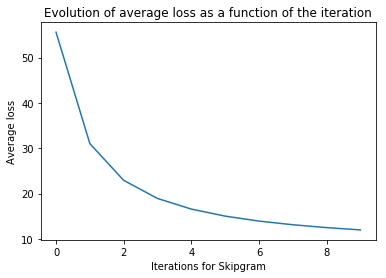

In [33]:
iteration= list(range(len(avg_losses)))

plt.plot(iteration, avg_losses)
plt.xlabel("Iterations for Skipgram")
plt.ylabel('Average loss')
plt.title('Evolution of average loss as a function of the iteration')
plt.savefig("Skipgram.png")
plt.show()


In [27]:
len(avg_losses)

612